# Neural Networks

In [1]:
import time
import os
import pprint
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tqdm.notebook as tq
import utils
from pydub import AudioSegment
from tkinter import Tcl # file sorting by name

# Creation of labels

### Dictionary creation for the classes

We want a dictionary indicating a numbeer for each genre:

{0: 'Hip-Hop', 1: 'Pop', 2: 'Folk', 3: 'Rock', 4: 'Experimental', 5: 'International', 6: 'Electronic', 7: 'Instrumental'}

### Creation of the labels vector

In [2]:
def create_single_dataset(folder_path, tracks_dataframe, genre_dictionary):    
    labels = []
   
    _, file_list = get_sorted_file_paths(folder_path)
    
    for i,file in enumerate(file_list):
        #print("considering file:",file, "({}/{})".format(i,len(file_list)))
        track_id_clip_id = file.split('.')[0]
        track_id = track_id_clip_id.split('_')[0]
        #print("track id with clip: {}, track id: {}".format(track_id_clip_id, track_id))
        genre = tracks_dataframe.loc[int(track_id)]
        #print("genre from dataframe: ", genre)
        label = genre_dictionary[genre]
        #print("label from dictionary:",label)
        labels.append(label)
    print("labels length: {}".format(len(labels)))
    return labels
    

#create the train,validation and test vectors using the files in the train/validation/test folders
def create_dataset_splitted(folder_path):
    train_folder = os.path.join(folder_path,'train') # concatenate train folder to path
    validation_folder = os.path.join(folder_path,'validation') # concatenate train folder to path
    test_folder = os.path.join(folder_path,'test') # concatenate train folder to path
    
    print("train_folder:",train_folder)
    print("validation_folder:",validation_folder)
    print("test_folder:",test_folder,"\n")
    
    AUDIO_DIR = os.environ.get('AUDIO_DIR')
    print("audio directory: ",AUDIO_DIR)
    print("Loading tracks.csv...")
    tracks = utils.load('data/fma_metadata/tracks.csv')
    
    #get only the small subset of the dataset
    small = tracks[tracks['set', 'subset'] <= 'small']
    print("small dataset shape:",small.shape)    

    small_training = small.loc[small[('set', 'split')] == 'training']['track']
    small_validation = small.loc[small[('set', 'split')] == 'validation']['track']
    small_test = small.loc[small[('set', 'split')] == 'test']['track']

    print("Track.csv: {} training samples, {} validation samples, {} test samples\n".format(len(small_training), len(small_validation), len(small_test)))

    small_training_top_genres = small_training['genre_top']
    small_validation_top_genres = small_validation['genre_top']
    small_test_top_genres = small_test['genre_top']
    
    #create dictionary of genre classes:
    unique_genres = small_training_top_genres.unique()
    unique_genres = np.array(unique_genres)
    print("there are {} unique genres".format(len(unique_genres)))
    genre_dictionary = {}
    for i,genre in enumerate(unique_genres):
        genre_dictionary[genre] = i
    print("Dictionary of genres created:",genre_dictionary)
    
    
    Y_train = create_single_dataset(train_folder, small_training_top_genres, genre_dictionary)
    Y_validation = create_single_dataset(validation_folder, small_validation_top_genres, genre_dictionary)
    Y_test = create_single_dataset(test_folder, small_test_top_genres, genre_dictionary)
    
    return Y_train, Y_validation, Y_test
 
def get_sorted_file_paths(folder_path):
    file_list = os.listdir(folder_path)
    #sort the dataset files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_list = Tcl().call('lsort', '-dict', file_list) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_list] #join filename with folder path
    #print("There are {} in the folder: {}".format(len(file_list),file_list))
    return file_paths, file_list
    
    
folder_path="data/fma_small_stft_transposed_22050_overlapped"
Y_train, Y_validation, Y_test = create_dataset_splitted(folder_path)

train_folder: data/fma_small_stft_transposed_22050_overlapped/train
validation_folder: data/fma_small_stft_transposed_22050_overlapped/validation
test_folder: data/fma_small_stft_transposed_22050_overlapped/test 

audio directory:  ./data/fma_small/
Loading tracks.csv...
small dataset shape: (8000, 52)
Track.csv: 6400 training samples, 800 validation samples, 800 test samples

there are 8 unique genres
Dictionary of genres created: {'Hip-Hop': 0, 'Pop': 1, 'Folk': 2, 'Rock': 3, 'Experimental': 4, 'International': 5, 'Electronic': 6, 'Instrumental': 7}
labels length: 127940
labels length: 16000
labels length: 16000


# Dataset Class

In [3]:
# Define the custom class for accessing our dataset
class MyDataset(Dataset):
    def __init__(self, file_list, labels, transform=None, verbose = False):
        self.file_list = file_list
        self.labels=labels
        self.transform = transform
        self.verbose = verbose

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # returns a training sample and its label
        file_path = self.file_list[idx]
        label = torch.tensor(self.labels[idx])
        stft_vector = torch.tensor(np.load(file_path)) #load from file
        
        # Normalize your data here
        if self.transform:
            if(self.verbose==True):
                print("TRANSFORM: applying transform to tensor shape:",stft_vector.shape,"content:",stft_vector)
            stft_vector = self.transform(torch.unsqueeze(stft_vector, dim=0)) #unsqueeze needed for the torchvision normalize method
            if(self.verbose==True):
                print("TRANSFORM: after transform shape:",stft_vector.shape,"content:",stft_vector)
            stft_vector = torch.squeeze(stft_vector, dim=0)
            if(self.verbose==True):
                print("TRANSFORM: after squeeze shape:",stft_vector.shape,"content:",stft_vector)

        
        return stft_vector, label

In [4]:
folder_path="data/fma_small_stft_transposed_22050_overlapped"

train_folder = os.path.join(folder_path,'train') # concatenate train folder to path
validation_folder = os.path.join(folder_path,'validation') # concatenate train folder to path
test_folder = os.path.join(folder_path,'test') # concatenate train folder to path

train_file_paths, _ = get_sorted_file_paths(train_folder)
train_dataset = MyDataset(train_file_paths, Y_train)
print("len of train dataset: ",len(train_dataset))

validation_file_paths, _ = get_sorted_file_paths(validation_folder)
validation_dataset = MyDataset(validation_file_paths, Y_validation)
print("len of validation dataset: ",len(validation_file_paths))

test_file_paths, _ = get_sorted_file_paths(test_folder)
test_dataset = MyDataset(test_file_paths, Y_test)
print("len of test dataset: ",len(test_dataset))

len of train dataset:  127940
len of validation dataset:  16000
len of test dataset:  16000


In [5]:
def check_for_dimension_errors(filepaths):
    error_indexes = []
    progress = 0
    for file in filepaths:
        progress+=1
        print("checked {}/{} files".format(progress,len(filepaths)))
        x = np.load(file)
        if(x.shape != (128,513)):
            error_indexes.append(x)
            print("error")
    print("{} errors found in files: {}".format(len(error_indexes),error_indexes))
    for idx,error in enumerate(error_indexes):
        print("index: {}, shape: {}".format(idx,error.shape))

# Data normalization
We will use Z-Score to normalize the training, validation and test set by calculating the mean and the std deviation on the training set.

In [7]:
save_filename = './data/fma_small_stft_transposed_22050_overlapped/train_mean'
std_save_filename = './data/fma_small_stft_transposed_22050_overlapped/train_std_deviation'


## Calculation of mean and standard deviation (Long)

In [10]:
batch_size=1
total_n_batches = len(train_dataset)/batch_size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
current_sum=0

#iter all the training set by batches and calculate the sum of all the sample values (513*128 values for each sample)
for batch_idx, batch in enumerate(train_loader):
    #print("batch",batch_idx,"/",total_n_batches,"current_sum:",current_sum)
    inputs = batch[0]
    labels = batch[1]
    #print("inputs: shape:",inputs.shape,"content:",inputs)
    #print("labels:",labels)
    for sample in inputs:
        #print("sample: shape",sample.shape,"content:",sample)
        current_sum += torch.sum(sample)
        #print("current_sum:",current_sum)
print("final sum:",current_sum)



final sum: tensor(8.9296e+09)


In [11]:
mean = current_sum/(len(train_dataset)*513*128) #divide the sum for the total number of values considerated
print("mean of training set:",mean)

print("Saving the mean in file:",save_filename) 
np.save(save_filename,mean)

mean of training set: tensor(1.0629)
Saving the mean in file: ./data/fma_small_stft_transposed_22050_overlapped/train_mean


In [13]:
#now let's calculate the standard deviation (squared root of the variance)

batch_size=1
total_n_batches = len(train_dataset)/batch_size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
current_sum_of_squares = 0

for batch_idx, batch in enumerate(train_loader):
    #print("batch",batch_idx,"/",total_n_batches,"current_sum_of_squares:",current_sum_of_squares)
    inputs = batch[0]
    labels = batch[1]
    #print("inputs: shape:",inputs.shape,"content:",inputs)
    #print("labels:",labels)
    for sample in inputs:
        #print("sample shape",sample.shape)
        for row in sample:
            #print("row shape:",row.shape)
            for elem in row:
                #print("elem: shape",elem.shape,"content:",elem)
                difference = elem - mean
                difference_squared = difference**2
                current_sum_of_squares += difference_squared
                #print("current_sum:",current_sum)
print("final sum of squares:",current_sum_of_squares)


final sum of squares: tensor(7.8299e+10)


In [14]:
import math

variance = current_sum_of_squares/((len(train_dataset) * 513 * 128)-1)
std_deviation = math.sqrt(variance)

print("variance:",variance)
print("std_deviation:",std_deviation)

print("Saving the std_deviation in file:",std_save_filename) 
np.save(std_save_filename,std_deviation)

variance: tensor(9.3202)
std_deviation: 3.0528938510507846
Saving the std_deviation in file: ./data/fma_small_stft_transposed_22050_overlapped/train_std_deviation


## Load calculated mean and std deviation from file

In [8]:
loaded_mean = np.load(save_filename+'.npy')
print("loaded mean:",loaded_mean)

loaded_std = np.load(std_save_filename+'.npy')
print("loaded std:",loaded_std)

loaded mean: 1.0629134
loaded std: 3.0528938510507846


## Create the normalized dataset

In [9]:
from torchvision import transforms

batch_size = 1

transform = transforms.Compose([
    transforms.Normalize(mean= loaded_mean, std= loaded_std)
])

train_dataset = MyDataset(train_file_paths, Y_train,  transform = transform)
validation_dataset = MyDataset(validation_file_paths, Y_validation,  transform = transform)
test_dataset = MyDataset(test_file_paths, Y_test,  transform = transform)

'''
#verify that the normalization has worked
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
total_n_batches = len(train_loader)/batch_size

#iter all the training set by batches and normalize the value of each tensor
for batch_idx, batch in enumerate(train_loader):
    print("batch",batch_idx,"/",total_n_batches)
    inputs = batch[0]
    labels = batch[1]
    print("inputs: shape:",inputs.shape,"content:",inputs)
    print("labels:",labels)
    for sample in inputs:
        print("sample: shape",sample.shape,"content:",sample)
   
validation_dataset = MyDataset(validation_file_paths, Y_validation,  transform = transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
total_n_batches = len(validation_loader)/batch_size

#iter all the training set by batches and normalize the value of each tensor
for batch_idx, batch in enumerate(validation_loader):
    print("batch",batch_idx,"/",total_n_batches)
    inputs = batch[0]
    labels = batch[1]
    print("inputs: shape:",inputs.shape,"content:",inputs)
    print("labels:",labels)
    for sample in inputs:
        print("sample: shape",sample.shape,"content:",sample)
'''

'\n#verify that the normalization has worked\ntrain_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)\ntotal_n_batches = len(train_loader)/batch_size\n\n#iter all the training set by batches and normalize the value of each tensor\nfor batch_idx, batch in enumerate(train_loader):\n    print("batch",batch_idx,"/",total_n_batches)\n    inputs = batch[0]\n    labels = batch[1]\n    print("inputs: shape:",inputs.shape,"content:",inputs)\n    print("labels:",labels)\n    for sample in inputs:\n        print("sample: shape",sample.shape,"content:",sample)\n   \nvalidation_dataset = MyDataset(validation_file_paths, Y_validation,  transform = transform)\nvalidation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)\ntotal_n_batches = len(validation_loader)/batch_size\n\n#iter all the training set by batches and normalize the value of each tensor\nfor batch_idx, batch in enumerate(validation_loader):\n    print("batch",batch_idx,"/",total_n_b

# Network Architecture Definition (nnet1)

In [10]:
class NNet1(nn.Module):
    def __init__(self):
        super(NNet1, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, kernel_size=(4, 513))
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(128, 128, kernel_size=(4, 1))
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 1))
        self.bn3 = nn.BatchNorm2d(64)
        self.avgpool = nn.AvgPool2d(kernel_size=(26, 1))
        self.maxpool = nn.MaxPool2d(kernel_size=(26, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.dense1 = nn.Linear(512, 300)
        self.bn4 = nn.BatchNorm1d(300)
        self.dense2 = nn.Linear(300,150)
        self.bn5 = nn.BatchNorm1d(150)
        self.dense3 = nn.Linear(150, 8)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x.float())
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x_avg = self.avgpool(x)
        x_max = self.maxpool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.softmax(x)
        return x

# Hyperparameters

In [11]:
BATCH_SIZE=32
EPOCHS=10
LEARNING_RATE=0.0001

learning_rate_list = [0.01, 0.001, 0.0001]
batch_size_list = [128,256,512]

# Train function

In [12]:
def test(model, validation_dataset, Y_validation):
    # Stop parameters learning
    model.eval()

    validation_loader = torch.utils.data.DataLoader(validation_dataset)

    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    confusion_matrix = np.zeros((8, 8), dtype=int)

    with torch.no_grad():
        for sample, label in validation_loader:
            
            sample = sample.unsqueeze(1)

            # Predict label
            output = model(sample)
            
            # Compute loss
            loss = criterion(output, label)
            total_loss += loss.item()

            max_index = torch.argmax(output).item()  # The index with maximum probability

            confusion_matrix[label][max_index] += 1

            correct += (max_index == label)

    cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm.plot()
    print(confusion_matrix)
    accuracy = 100 * correct / len(Y_validation)
    average_loss = total_loss / len(Y_validation)

    model.train()
    return accuracy, average_loss

In [13]:
def train(model, dataset, batch_size, num_epochs, learning_rate, verbose = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    val_loss_list=[]
    val_acc_list=[]
    train_loss_list=[]
    train_acc_list=[]
    counted_labels=[0,0,0,0,0,0,0,0]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
    criterion = nn.CrossEntropyLoss()

    if not isinstance(dataset, Dataset):
        raise ValueError("The dataset parameter should be an instance of torch.utils.data.Dataset.")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_accuracy = 0.0
        #initialize correctly predicted samples
        
        # Initialize the progress bar
        progress_bar = tq.tqdm(total=num_batches, unit="batch")
    
        # Initialize the progress bar description
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()
        
        for batch_idx, batch in enumerate(data_loader):
            
            correct = 0 # reset train accuracy each batch
            
            inputs,labels = batch[0],batch[1]
            if(verbose == True):
                print("\ninputs shape:",inputs.size(),", content: ",inputs)
                print("min value:",torch.min(inputs))
                print("max value:",torch.max(inputs))
                print("\nlabels shape:",labels.size(),", content: ",labels)
            inputs = inputs.unsqueeze(1)
            
            # Extract the inputs and targets
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if(verbose == True):
                print("\noutputs size:",outputs.size(),"content:",outputs)
                print("List of labels until now:",counted_labels)

            loss = criterion(outputs, labels) #labels need to be a vector of class indexes (0-7) of dim (batch_size)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            #calculate train accuracy
            for index, output in enumerate(outputs):
                max_index = torch.argmax(output).item() #the index with maximum probability
                counted_labels[labels[index].item()]+=1
                if(labels[index].item() == max_index):
                    correct += 1
            
                if(verbose==True):
                    print("considering output at index {}:".format(index,output))
                    print("max output index = {}",max_index)
                    if(labels[index].item() == max_index):
                        print("correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))
                    else:
                        print("NOT correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))

            
            accuracy = 100 * correct / batch_size
            running_accuracy += accuracy #epoch running_accuracy
            
            # Update the progress bar description and calculate bps
            #progress_bar.set_postfix({"Loss": running_loss / (batch_idx + 1)})
            average_accuracy = running_accuracy / (batch_idx + 1)
            average_loss = running_loss / (batch_idx + 1)
            progress_bar.set_postfix({"avg_loss": average_loss, "acc": accuracy, "avg_acc": average_accuracy})

            # Update the progress bar
            progress_bar.update(1)
            # Evaluate the model on the validation dataset
        
        #calculate train loss and accuracy
        average_loss = running_loss / len(data_loader)
        average_accuracy = running_accuracy / len(data_loader)
        train_loss_list.append(average_loss)
        train_acc_list.append(average_accuracy)
        
        #calculate validation loss and accuracy
        val_acc, val_loss = test(model, validation_dataset, Y_validation)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {average_loss:.4f}. Train Accuracy: {average_accuracy} Val Loss: {val_loss} Val Accuracy: {val_acc}")
        progress_bar.close()
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [34]:
#summary(model, (1, 128, 513))
performance_list = []
model_list = []
directory = 'models/'

for lr in learning_rate_list:   
    for bs in batch_size_list:
        model = NNet1() #reinitialize model
        file_path = directory + 'model' + '_lr_' + str(lr).split('.')[0] + '-' + str(lr).split('.')[1]+ '_bs_' + str(bs)
        print(f"Traing model with batch size={bs}, lr={lr}")
        performance=train(model, train_dataset, batch_size=bs, num_epochs=EPOCHS, learning_rate=lr, verbose=True)
        performance_list.append(performance)
        model_list.append(model)
        print("saving model in", file_path)
        torch.save(model.state_dict(), file_path)
        print(performance_list)

NameError: name 'NNet1' is not defined

In [35]:
'''
plt.plot(np.arange(1,EPOCHS+1), performance[1][:], label='Loss') 
plt.plot(np.arange(1,EPOCHS+1), performance[0][:], label='Accuracy')
plt.legend()  # Display the legend showing the labels
plt.show()
print(performance[0][:])
'''

parameter_list = []
for lr in learning_rate_list:
    for bs in batch_size_list:
        parameter_list.append([lr,bs])

for performance, parameters in zip(performance_list, parameter_list):
    plt.plot(np.arange(1,EPOCHS+1), performance[1][:], label='Val Loss') 
    plt.plot(np.arange(1,EPOCHS+1), performance[0][:], label='Val Accuracy')
    plt.title(f"Lr = {parameters[0]}, Batch size = {parameters[1]}")
    plt.legend()  # Display the legend showing the labels
    plt.show()
    print(performance[0][:])


# Network Architecture Definition (nnet1 + BN)

In [15]:
class NNet1_Small(nn.Module):
    def __init__(self):
        super(NNet1_Small, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(2, 513))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=(4, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(2, 1))
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(4, 1))
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(2, 1))
        self.bn3 = nn.BatchNorm2d(64)
        self.avgpool = nn.AvgPool2d(kernel_size=(3, 1))
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        self.dense1 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dense2 = nn.Linear(128,32)
        self.bn5 = nn.BatchNorm1d(32)
        self.dense3 = nn.Linear(32, 8)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x.float())
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x_avg = self.avgpool(x)
        x_max = self.maxpool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.softmax(x)
        return x

In [16]:
model_NNet1_Small = NNet1_Small()
summary(model_NNet1_Small, (1, 128, 513))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 127, 1]          32,864
       BatchNorm2d-2           [-1, 32, 127, 1]              64
              ReLU-3           [-1, 32, 127, 1]               0
         MaxPool2d-4            [-1, 32, 31, 1]               0
            Conv2d-5            [-1, 64, 30, 1]           4,160
       BatchNorm2d-6            [-1, 64, 30, 1]             128
              ReLU-7            [-1, 64, 30, 1]               0
         MaxPool2d-8             [-1, 64, 7, 1]               0
            Conv2d-9             [-1, 64, 6, 1]           8,256
      BatchNorm2d-10             [-1, 64, 6, 1]             128
        AvgPool2d-11             [-1, 64, 2, 1]               0
        MaxPool2d-12             [-1, 64, 2, 1]               0
          Flatten-13                  [-1, 256]               0
           Linear-14                  [

  0%|          | 0/1000 [00:00<?, ?batch/s]

[[1015    0   78   14   30  232  605   26]
 [ 152    0  333  225  293  266  399  332]
 [  15    0 1216   60    5  140   11  553]
 [  41    0  211 1194  220  166   48  120]
 [  22    0  246  121  416  111  191  893]
 [  44    0  278   38   32 1057  142  409]
 [ 180    0   61   32  123  248 1013  343]
 [   4    0  393  162  223  190  145  883]]
Epoch [1/20],Train Loss: 1.8367. Train Accuracy: 45.1453125 Val Loss: 1.8423980750367046 Val Accuracy: tensor([42.4625])


  0%|          | 0/1000 [00:00<?, ?batch/s]

[[ 974    0   85   45   58  177  639   22]
 [ 109    0  294  379  461  171  367  219]
 [   8    0 1214  140  221  113    1  303]
 [   8    0  249 1420  114   71   34  104]
 [  21    0  211  229 1159   54   99  227]
 [  32    0  169   44  395 1094  126  140]
 [ 176    0   40   66  306  185  999  228]
 [   3    0  322  275  400  110   98  792]]
Epoch [2/20],Train Loss: 1.7614. Train Accuracy: 51.7796875 Val Loss: 1.7946505519449711 Val Accuracy: tensor([47.8250])


  0%|          | 0/1000 [00:00<?, ?batch/s]

KeyboardInterrupt: 

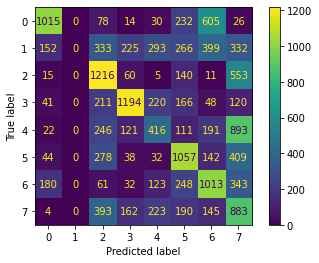

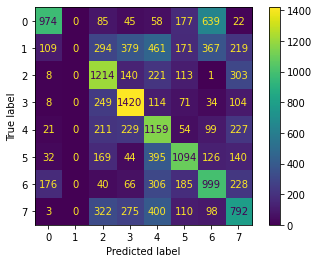

In [114]:


train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model_NNet1_BN, train_dataset, batch_size=128, num_epochs=20, learning_rate=0.001)


# Raw audio (1D)

## Raw audio dataset

In [118]:
# Define the custom class for accessing our dataset of way audio
#class MyDatasetRaw(Dataset):
    #def __init__(self, file_list, labels):
        #self.file_list = file_list
        #self.labels=labels

    #def __len__(self):
        #return len(self.file_list)

    #def __getitem__(self, idx):
        # returns a training sample and its label
        #file_path = self.file_list[idx]
        #label = torch.tensor(self.labels[idx])
        
        #print("opening file:",file_path)
        #audio_file = AudioSegment.from_file(file_path)

        #data = audio_file._data
        #pcm16_signed_integers = []

        # This loop decodes the bytestring into PCM samples.
        # The bytestring is a stream of little-endian encoded signed integers.
        # This basically just cuts each two-byte sample out of the bytestring, converts
        # it to an integer, and appends it to the list of samples.
        #for sample_index in range(len(data)//2):
            #sample = int.from_bytes(data[sample_index*2:sample_index*2+2], 'big', signed=True)
            #pcm16_signed_integers.append(sample)


        #load audio in ram
        #x = np.load(file_path,allow_pickle=True) #load the MONO audio file from the data/fma_small directory
        #x=torch.tensor(pcm16_signed_integers)
        #x = x.type(torch.FloatTensor)
        #print(x.shape)
        
        # Load the MP3 file
        #audio = AudioSegment.from_mp3(file_path)

        # Set the desired new sampling rate
        #new_sampling_rate = 8000  # for example, 16000 Hz

        # Resample the audio to the new sampling rate
        #resampled_audio = audio.set_frame_rate(new_sampling_rate)

        # Convert the resampled audio to a raw PCM array
        #resampled_pcm_audio = resampled_audio.raw_data
        #resampled_pcm_array = np.frombuffer(resampled_pcm_audio, dtype=np.int16)
        
        #print("Versione 2:",resampled_pcm_array.size,"\tVersione 1:",x.shape)
        #x=torch.tensor(resampled_pcm_array)
        #x = x.type(torch.FloatTensor)
        #àreturn x, label
    
# Define the custom class for accessing our dataset
class MyDatasetRaw(Dataset):
    def __init__(self, file_list, labels):
        self.file_list = file_list
        self.labels=labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = torch.tensor(self.labels[idx])
        raw_vector = np.load(file_path).astype(np.int16)  # Ensure int16 data type
        raw_vector = torch.tensor(raw_vector)
        return raw_vector[:200000], label
        

In [119]:
#returns file paths list for train, validation and test
def get_file_paths():
    folder_raw = './data/fma_small'
    file_paths_raw = []

    AUDIO_DIR = os.environ.get('AUDIO_DIR')
    print("audio directory: ",AUDIO_DIR)
    print("Loading tracks.csv...")
    tracks = utils.load('data/fma_metadata/tracks.csv')

    #get only the small subset of the dataset
    small = tracks[tracks['set', 'subset'] <= 'small']
    print("small dataset shape:",small.shape)    

    small_training = small.loc[small[('set', 'split')] == 'training']['track']
    small_validation = small.loc[small[('set', 'split')] == 'validation']['track']
    small_test = small.loc[small[('set', 'split')] == 'test']['track']

    print("Track.csv: {} training samples, {} validation samples, {} test samples\n".format(len(small_training), len(small_validation), len(small_test)))
    
    #--------------TRAIN----------------------
    print("Creating train dataset...")
    file_paths_train = []

    #we have to get train track_ids from dataframe
    track_ids_train = np.array(small_training.index) #get indexes and convert to numpy array
    print(f"There are {len(track_ids_train)} samples. Here's the first ones: {track_ids_train[:10]}")

    for track_id in track_ids_train:
        file_path = utils.get_audio_path(AUDIO_DIR,track_id)
        file_paths_train.append(file_path)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_train = np.array(Tcl().call('lsort', '-dict', file_paths_train)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    #--------------VALIDATION----------------------
    print("Creating validation dataset...")
    file_paths_validation = []

    #we have to get train track_ids from dataframe
    track_ids_validation = np.array(small_validation.index) #get indexes and convert to numpy array
    print(f"There are {len(track_ids_validation)} samples. Here's the first ones: {track_ids_validation[:10]}")

    for track_id in track_ids_validation:
        file_path = utils.get_audio_path(AUDIO_DIR,track_id)
        file_paths_validation.append(file_path)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_validation = np.array(Tcl().call('lsort', '-dict', file_paths_validation)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    #--------------TEST----------------------
    print("Creating test dataset...")
    file_paths_test = []

    #we have to get train track_ids from dataframe
    track_ids_test = np.array(small_test.index) #get indexes and convert to numpy array
    print(f"There are {len(track_ids_test)} samples. Here's the first ones: {track_ids_test[:10]}")

    for track_id in track_ids_test:
        file_path = utils.get_audio_path(AUDIO_DIR,track_id)
        file_paths_test.append(file_path)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_test = np.array(Tcl().call('lsort', '-dict', file_paths_test)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    
    #create the datasets
    
    return file_paths_train, file_paths_validation, file_paths_test

#returns file paths list for train, validation and test for each 3s clip
def get_file_paths_split():
    folder_raw = './data/fma_small_raw_array'
    folder_train = folder_raw + '/train'
    folder_validation = folder_raw + '/validation'
    folder_test = folder_raw + '/test'
    file_paths_raw = []

    #--------------TRAIN----------------------
    print("Creating train dataset...")
    file_paths_train = os.listdir(folder_train)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_train = np.array(Tcl().call('lsort', '-dict', file_paths_train)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    complete_file_path_train = []
    for file in file_paths_train:
        complete_file_path_train.append(folder_train + '/' + file)

    #--------------VALIDATION----------------------
    print("Creating validation dataset...")
    file_paths_validation = os.listdir(folder_validation)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_validation = np.array(Tcl().call('lsort', '-dict', file_paths_validation)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    complete_file_path_validation = []
    for file in file_paths_validation:
        complete_file_path_validation.append(folder_validation + '/' + file)

    #--------------TEST----------------------
    print("Creating test dataset...")
    file_paths_test = os.listdir(folder_test)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_test = np.array(Tcl().call('lsort', '-dict', file_paths_test)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    complete_file_path_test = []
    for file in file_paths_test:
        complete_file_path_test.append(folder_test + '/' + file)
    
    return complete_file_path_train, complete_file_path_validation, complete_file_path_test



In [120]:
file_paths_train, file_paths_validation, file_paths_test = get_file_paths_split()
print(len(file_paths_train))
print(len(file_paths_validation))
print(len(file_paths_test))

Creating train dataset...


TypeError: iteration over a 0-d array

## Fix wrong sampling rates in the dataset

Some songs in the fma_small dataset has a different sampling rate from 44100. Let's fix them by using librosa resampling tool.

In [ ]:
import soundfile as sf

#fix sampling rate
target_sr = 44100
wrong_sr_list = []

"""
print("\n******Checking sample rates to be",target_sr,"in train set")
for file in file_paths_train:
    x, sr = librosa.load(file,sr=None)
    if(sr!=target_sr):
        print("wrong sr found! value:",sr,"resampling to",target_sr,"...")
        x = librosa.resample(x,orig_sr=sr,target_sr=target_sr)
        print("saving new resampled file in",file,"...")
        # Write out audio as 24bit PCM WAV
        sf.write(file, x, target_sr, format='mp3')    
        wrong_sr_list.append(file)
   """     
print("\n*****Checking sample rates to be",target_sr,"in validation set")
for file in file_paths_validation:
    x, sr = librosa.load(file,sr=None)
    if(sr!=target_sr):
        print("wrong sr found! value:",sr,"resampling to",target_sr,"...")
        x = librosa.resample(x,orig_sr=sr,target_sr=target_sr)
        print("saving new resampled file in",file,"...")
        # Write out audio as 24bit PCM WAV
        sf.write(file, x, target_sr, format='mp3')    
        wrong_sr_list.append(file)

        
print("\n*****Checking sample rates to be",target_sr,"in test set")
for file in file_paths_test:
    x, sr = librosa.load(file,sr=None)
    if(sr!=target_sr):
        print("wrong sr found! value:",sr,"resampling to",target_sr,"...")
        x = librosa.resample(x,orig_sr=sr,target_sr=target_sr)
        print("saving new resampled file in",file,"...")
        # Write out audio as 24bit PCM WAV
        sf.write(file, x, target_sr, format='mp3')    
        wrong_sr_list.append(file)
        
print("There were a total of",len(wrong_sr_list),"files with wrong sampling rate. Now they have been corrected")

## Create labels for raw audio

We have to take one label each ten from Y_label. Now we are not using 10 clips for each audio but just the whole audio itself.

## Create dataset for raw audio

In [ ]:
train_dataset = MyDatasetRaw(file_paths_train, Y_train)
validation_dataset = MyDatasetRaw(file_paths_validation, Y_validation)
test_dataset = MyDatasetRaw(file_paths_test, Y_test)

In [ ]:
class NNet_Raw3(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NNet_Raw3, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=8, stride=16)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=8, stride=8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(128) 
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(24960, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 8)
        
    def forward(self, x):
        x = self.conv1(x.float())
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
MyModel=NNet_Raw()
summary(MyModel, (1,200000))
print(MyModel)

In [ ]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list =train_raw(MyModel, train_dataset, batch_size=128, num_epochs=10, learning_rate=0.1, verbose=False)